## STL-10 Demo
This is the second part of demo on the reduced STL-10 dataset taken from Stanford's [UFLDL tutorial](http://deeplearning.stanford.edu/wiki/index.php/UFLDL_Tutorial). The original [STL-10 dataset](https://cs.stanford.edu/~acoates/stl10/) has 10 classes (airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck). This reduced dataset contains the images from 4 of the classes (airplane, car, cat, dog).

In the [first part of the demo]() we used a sparse autoencoder neural network to pre-train weights for a convolution layer. In this part we use those weights in a convolutional neural network and predict labels for the images.

### Load Alice
And best to start with multiple threads for speed.

In [1]:
using Alice

In [2]:
Base.Threads.nthreads()

4

### Load the images

The size of each image is 64 x 64 pixels x 3 channels (RGB).  
The training set contains 2000 images (500 from each class) and the test set contains 3200 images (800 from each class).

The data can be loaded using the functions **`load_train_subset`** and **`load_test_subset`**.

In [3]:
train_images, train_labels = load_train_subset()
test_images, test_labels = load_test_subset()
image_dim, _, num_channels, num_images = size(train_images)

(64,64,3,2000)

In [4]:
[sum(train_labels .== i) / num_images for i in [1, 2, 3, 4]]'

1×4 Array{Float64,2}:
 0.25  0.25  0.25  0.25

In [5]:
function display_stl10(images, num_rows, num_cols)

    # Size of array
    xdim, ydim, num_channels, num_images = size(images)

    # Choose how many images to display and select a random subset
    num_disp = num_rows * num_cols
    selection = rand(1:num_images, num_disp)

    # Initialise empty outer array to push image arrays into
    I = Array(Array{Float64, 3}, 0)

    # Create blank canvas with some padding, copy image into canvas, and then push to outer array
    img = ones(xdim + 2, ydim + 2, num_channels)
    for im in selection
        img[2:(xdim + 1), 2:(ydim + 1), :] = images[:, :, :, im]
        push!(I, copy(img))
    end

    # Concatenate the vector of image matrices into a single large matrix
    I = hvcat(num_cols, I...)

    # Display
    colorview(RGB, permutedims(I, [3,1,2]))
end;

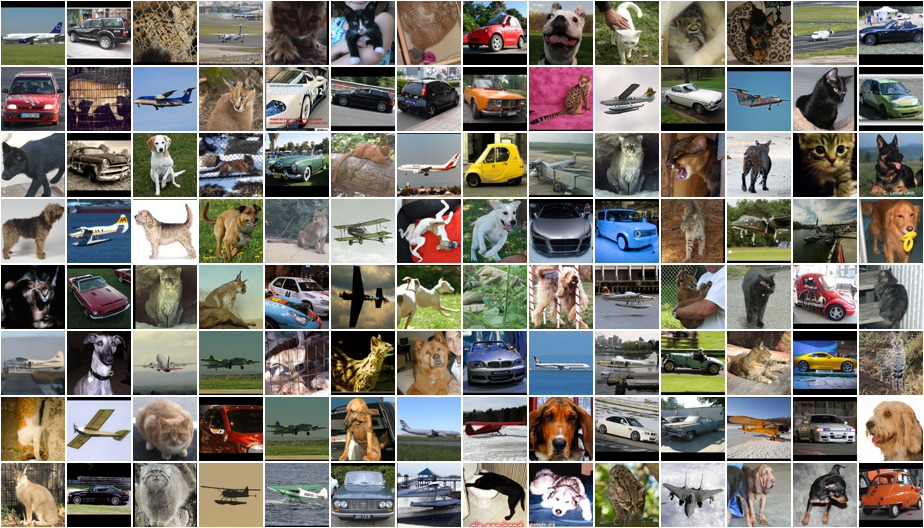

In [6]:
display_stl10(train_images, 8, 14)

### Load the pre-trained network weights from the autoencoder
The pre-trained features can be accessed from the demo folder using the **`load_features`** function.

In [7]:
W, b = load_features();

The weights are in a matrix with dimensions `400 x 192 (8 * 8 * 3)`. We need to:
1. Reshape to `400 x 8 x 8 x 3`, and
2. Permute the dimensions of the array to `8 x 8 x 3 x 400` to fit with the convolution layer filter size in Alice

In [8]:
# Reshape the weights
patch_dim = 8
num_channels = 3
num_patches = 400
W = reshape(W, num_patches, patch_dim, patch_dim, num_channels)
W = permutedims(W, [2, 3, 4, 1])
patch_dims = size(W);

### Build convolutional neural network (without an output layer)

We could add a softmax output layer to the below and train. But because it take some time to run the covolutions and pooling on all the data (training and test data) instead we'll run all the data through the convolution and pool layers and then use the outputs of this operation as an input into a softmax regression. After this we could fine tune the entire network.

In [9]:
# Data Box and Input Layer
batch_size = 100
databox = Data(train_images, train_labels, test_images, test_labels)
input = InputLayer(databox, batch_size)

# Convolution Layer
conv_dims = (patch_dim, patch_dim, num_channels, num_patches)
conv1 = ConvolutionLayer(size(input), patch_dims, activation = :logistic)

# Input the pre-trained weights into the convolution layer
conv1.W[:] = W[:]
conv1.b[:] = b[:]

# Mean Pooling Layer
pooling_stride = 19
pool1 = MeanPoolLayer(size(conv1), pooling_stride)

# Neural Net
net1 = NeuralNet(databox, [input, conv1, pool1])

Neural Network
Training Data Dimensions - (64,64,3,2000)
Layers:
Layer 1 - Alice.InputLayer{Float64}, Dimensions - (64,64,3,100)
Layer 2 - Alice.ConvolutionLayer{Float64}, Activation - Alice.logistic, Dimensions - (57,57,400,100)
Layer 3 - Alice.MeanPoolLayer{Float64}, Dimensions - (3,3,400,100)


#### Feedforward all data through the network
Save the output features to use in a softmax regression.

In [10]:
function create_feats(net, X)
    
    # Counts of images, patches and batches
    num_obs = size(X)[end]
    num_batches = div(num_obs, net.batch_size)
    
    # Useful handles: ℓ1 = first layer, L = final layer
    ℓ1 = net.layers[1]
    L = net.layers[end]
    
    # Create output features array
    feats = zeros(size(L)[1:3]..., num_obs)
    
    # Print header
    println("Completed batches (total is $num_batches):")
    
    # Run through each batch
    for batch = 1:num_batches
        
        # Update network with next batch
        stop = batch * net.batch_size
        start = stop - net.batch_size + 1
        ℓ1.A[:] = viewbatch(X, start, stop)
                
        # Feedforward
        fwd_prop!(net)
        
        # Update features array
        feats[:, :, :, start:stop] = L.A[:, :, :, :]
        
        # Print progress
        print("$batch, ")
    end
    
    return feats
end;

In [11]:
train_feats = create_feats(net1, net1.data.X_train);

Completed batches (total is 20):
1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 

In [12]:
test_feats = create_feats(net1, net1.data.X_val);

Completed batches (total is 32):
1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 

### Softmax Regression

The convolved and pooled features can now be used as inputs into a regression model.

#### Build the model

In [13]:
# Input
databox = Data(train_feats, train_labels, test_feats, test_labels)
batch_size = 400
input = InputLayer(databox, batch_size)

# Softmax Output Layer
num_classes = 4
output = SoftmaxOutputLayer(databox, size(input), num_classes)

# Model
λ = 1e-4    # Regularisation parameter
model = NeuralNet(databox, [input, output], λ)

Neural Network
Training Data Dimensions - (3,3,400,2000)
Layers:
Layer 1 - Alice.InputLayer{Float64}, Dimensions - (3,3,400,400)
Layer 2 - Alice.SoftmaxOutputLayer{Float64,Int64}, Dimensions - (4,400)


#### Train
This is a convex optimisation problem as there are no hidden layers i.e. it is a softmax regression / multiclass logistic regression model. The **`train_nlopt`** function (used for the sparse autoencoder) with full batch training could be used. But we can also use the main **`train`** function with stochastic mini-batch.

In [14]:
# Training parameters
α = 1e-1            # learning rate
μ = 0.95            # momentum
num_epochs = 400    # number of epochs

# Train
train(model, num_epochs, α, μ, nesterov = true, shuffle = true, last_train_every = 10, full_train_every = 40, val_every = 40)

15:45:06 : Epoch 10, last batch training error (with regⁿ) - 0.860
15:45:07 : Epoch 20, last batch training error (with regⁿ) - 0.671
15:45:08 : Epoch 30, last batch training error (with regⁿ) - 0.642
15:45:09 : Epoch 40, last batch training error (with regⁿ) - 0.635

Coffee break:
Training error (with regⁿ) - 0.618  |  Training accuracy - 77.4
Validation error (without regⁿ) - 0.645  |  Validation accuracy - 75.2

15:45:11 : Epoch 50, last batch training error (with regⁿ) - 0.613
15:45:12 : Epoch 60, last batch training error (with regⁿ) - 0.583
15:45:12 : Epoch 70, last batch training error (with regⁿ) - 0.548
15:45:13 : Epoch 80, last batch training error (with regⁿ) - 0.563

Coffee break:
Training error (with regⁿ) - 0.559  |  Training accuracy - 79.0
Validation error (without regⁿ) - 0.594  |  Validation accuracy - 77.8

15:45:14 : Epoch 90, last batch training error (with regⁿ) - 0.532
15:45:14 : Epoch 100, last batch training error (with regⁿ) - 0.565
15:45:15 : Epoch 110, last 

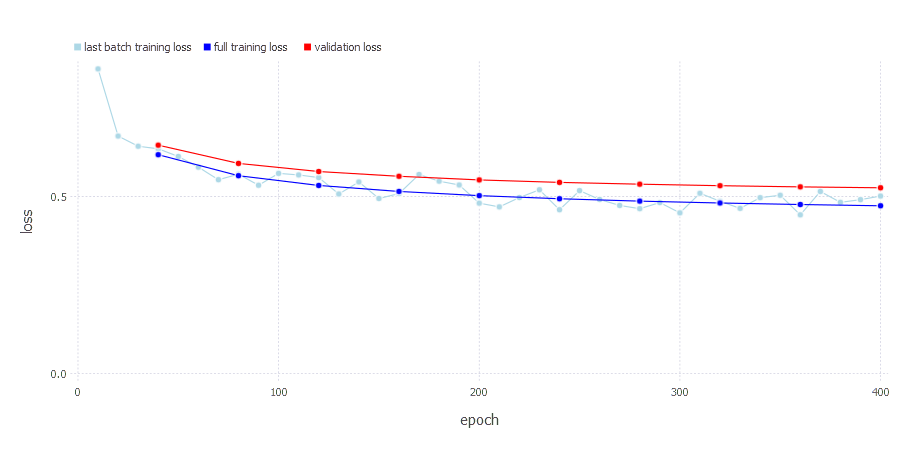

In [15]:
Gadfly.set_default_plot_size(24cm, 12cm)
plot_loss_history(model, 10, 40, 40)

### Result
The test set accuracy above is greater than 80% !

This could be improved by finetuning the weights (i.e. training the convolutional neural network starting with the pre-trained convolution weights and the softmax layer weights) as well as building further convolutionan layers that are also pre-trained by a sparse autoencoder.